# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
import statsmodels.api as sm

%matplotlib inline
#%tensorflow_version 1.x
#import tensorflow as tf
#print(tf.__version__)


## load dataset

In [2]:
dataset = pd.read_csv('SecundaIMO3.csv', sep =';', header=0, index_col=0)
values = dataset.values

## Plot pm2.5

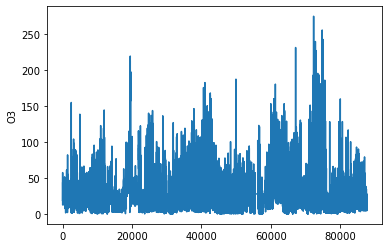

In [3]:
plt.plot(values[:,0])
plt.ylabel(dataset.columns[0])
plt.show()

## Data preparation

We need a way to prepare the data for whatever way we would like to formulate the problem.

In this case we are formulating it such that we take in 1 time step input (14 variables) and output 1 time step output (1 variable). In other words we are trying to solve the following question: given the pollution and weather conditions of the previous hour, can we predict the PM2.5 level for the next hour.

The single variable we are outputing is the PM2.5 level. Note we also use PM2.5 level in our input.

Credit for this code: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Get column names

In [5]:
dataset.columns

Index(['O3', 'PM2.5', 'PM10', 'SO2', 'NO2', 'NO', 'NOx', 'CO', 'Amb Wspeed',
       'Amb WDirection', 'Temperature', 'Amb RelHum', 'Amb Pressure', 'Rain'],
      dtype='object')

##Actually perform the data preparation

We scale the values between 0 and 1.

The code which converts the data into the suitable way we want, in this case, will produce 14 output variables. In our case we only want to predict PM2.5, that is why we drop the other collumns from the dataframe.

Credit for this code: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [6]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# We drop these because we are only interested in predicting for a single variable (pollution).
# If we don't drop, then we will be predicting for all the variables too!
reframed.drop(reframed.columns[[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,]], axis=1, inplace=True)
values = reframed.values

## View the data

In [7]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var1(t)
1,0.068915,0.009341,0.002724,0.011100,0.002253,0.002730,0.005174,0.000008,0.091213,0.590294,0.473337,0.963577,0.964391,0.0,0.083653
2,0.083653,0.004773,0.001281,0.011264,0.002089,0.002375,0.005479,0.000006,0.133054,0.354899,0.460366,0.963577,0.964130,0.0,0.110260
3,0.110260,0.010864,0.002736,0.010219,0.009678,0.003573,0.016519,0.000008,0.251883,0.194311,0.457896,0.914916,0.962036,0.0,0.075195
4,0.075195,0.008960,0.002235,0.014398,0.008230,0.003173,0.020939,0.000006,0.264435,0.164366,0.464072,0.853536,0.960557,0.0,0.095053
5,0.095053,0.006618,0.001772,0.012472,0.007440,0.003262,0.014299,0.000004,0.188285,0.205617,0.478279,0.785604,0.959420,0.0,0.109902


## Create X and Y variables

In [8]:
values.shape

(87646, 15)

In [9]:
X = values[:,:-1]

In [10]:
Y = values[:,-1]

In [11]:
X.shape

(87646, 14)

## Check the shapes

In [12]:
Y.shape

(87646,)

## Training, validation and testing split

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

## Check the shape

In [14]:
print ('X_train:',X_train.shape)
print ('Y_train:',Y_train.shape)
print ()
print ('X_val:',X_val.shape)
print ('Y_val:',Y_val.shape)
print ()
print ('X_test:',X_test.shape)
print ('Y_test:',Y_test.shape)

X_train: (56092, 14)
Y_train: (56092,)

X_val: (14024, 14)
Y_val: (14024,)

X_test: (17530, 14)
Y_test: (17530,)


## Define a model

In [15]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train )

LinearRegression()

## Print summary

In [16]:
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -0.032398388
Coefficients: 
 [ 0.8720599  -0.01972028 -0.03868127  0.01817536 -0.08407652  0.03820742
  0.00774749 -0.00111623  0.00367552  0.00518398  0.01276985  0.00149758
  0.03811879 -0.00835446]


## Predict

In [17]:
X_test = sm.add_constant(X_test)

In [18]:
model = sm.OLS(Y_test,  X_test).fit()

In [19]:
prediction = model.predict(X_test)

In [20]:
mean_absolute_error(Y_test, prediction)

0.02317194693075402

In [21]:
mean_squared_error(Y_test, prediction)

0.0016545953295454714

In [22]:
rmse = sqrt(mean_squared_error(Y_test, prediction))
print(rmse)

0.040676717290674666


In [23]:
r2_score(Y_test, prediction)

0.7761575924208304

In [24]:
print('accuracy testing = {}'.format(np.sum(prediction == Y_test)))

accuracy testing = 0


In [25]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     4338.
Date:                Tue, 18 Jul 2023   Prob (F-statistic):               0.00
Time:                        18:43:44   Log-Likelihood:                 31259.
No. Observations:               17530   AIC:                        -6.249e+04
Df Residuals:                   17515   BIC:                        -6.237e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0292      0.026     -1.127      0.2

## Compare prediction and testing data

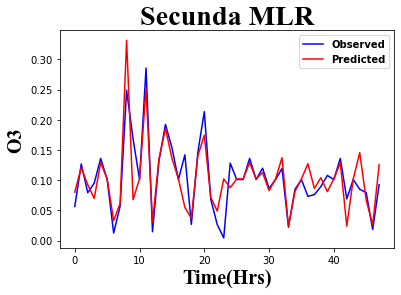

In [26]:
plt.plot(Y_test[0:48], color='blue', label = 'Observed')
plt.plot(prediction[0:48], color='red', label = 'Predicted')
plt.ylabel('O3', fontname="Times New Roman", size=20,fontweight="bold")
plt.xlabel('Time(Hrs)', fontname="Times New Roman", size=20,fontweight="bold")
plt.title('Secunda MLR', fontname="Times New Roman", size=28,fontweight="bold")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)
plt.show()

In [ ]:
mean_absolute_error(Y_test[1:6], prediction[1:6])

In [ ]:
mean_absolute_error(Y_test[1:12], prediction[1:12])

In [ ]:
mean_absolute_error(Y_test[1:18], prediction[1:18])

In [ ]:
mean_absolute_error(Y_test[1:24], prediction[1:24])

In [ ]:
mean_absolute_error(Y_test[1:36], prediction[1:36])

In [ ]:
mean_absolute_error(Y_test[1:48], prediction[1:48])

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:6], prediction[1:6]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:12], prediction[1:12]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:18], prediction[1:18]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:24], prediction[1:24]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:36], prediction[1:36]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:48], prediction[1:48]))
print(rmse)